# Malaria predictor: an image classification problem
# Training a Convolutional Neural Network with data augmentation

- Examples of loading and processing images
https://www.kaggle.com/crawford/resize-and-save-images-as-numpy-arrays-128x128
- Example on how to deal with images
https://www.kaggle.com/crawford/resize-and-save-images-as-numpy-arrays-128x128
- Example of an architecture of CNN for a similar task 
https://www.kaggle.com/crawford/lung-infiltration-cnn-with-keras-on-chest-x-rays
- Example of Data augmentation with keras
https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

To measure your model's performance by looking at prediction error, we'll use the log loss metric. This is a quantity in [0,∞) where a lower value is better, and is given by the following formula:

logloss(y^,y)=−1n∑i=1n[y^i⋅loge(y^i)+(1−yi)⋅loge(1−y^i)]
In this case, n=5,793 because you are being asked to classify 5,793 rows in the test set.


### Reading the data images

In [1]:
#import cv2
#from skimage import io
import os
import random
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np

%matplotlib inline 

In [2]:
# ../input/
DATA_PATH = os.path.abspath(os.path.join('.', 'data'))

# ./data/train
train_path = os.path.join(DATA_PATH, "train")

# ./data/test
test_path = os.path.join(DATA_PATH, "test")

# ../data/train/*.jpg
train_images = glob(os.path.join(train_path, "*.jpg"))
# ../data/train/*.jpg
test_images = glob(os.path.join(test_path, "*.jpg"))

# Load labels
labels = pd.read_csv('./data/train_labels.csv')


In [13]:
# Show some images using matplotlib
r = random.sample(train_images, 16)
img=plt.imread(r[0])

print('Data type: %s' % img.dtype)
print('Min: %.3f Max: %.3f ' %(img.min(),img.max()))

img= img/255
#img2=img /255.0

print('Data type: %s' % img.dtype)
print('Min: %.3f Max: %.3f ' %(img.min(),img.max()))

"""
# Matplotlib black magic
plt.figure(figsize=(20,20))
for i in range(16):
    pos=441+i
    print(pos,' ',type(pos))
    plt.subplot(441+i)
    plt.imshow(plt.imread(r[i]))

plt.show()
"""

Data type: uint8
Min: 0.000 Max: 255.000 
Data type: float64
Min: 0.000 Max: 1.000 


"\n# Matplotlib black magic\nplt.figure(figsize=(20,20))\nfor i in range(16):\n    pos=441+i\n    print(pos,' ',type(pos))\n    plt.subplot(441+i)\n    plt.imshow(plt.imread(r[i]))\n\nplt.show()\n"

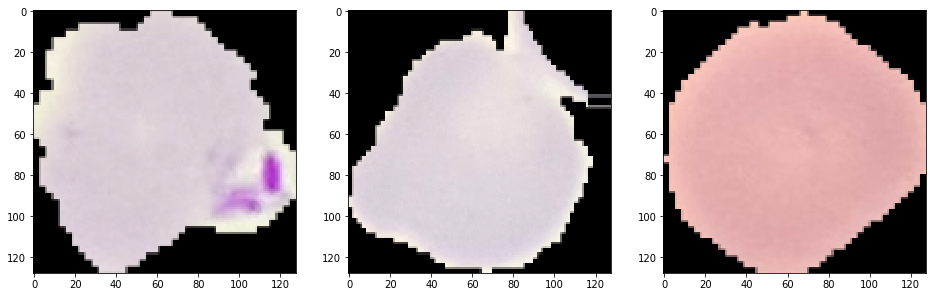

In [3]:
r = random.sample(train_images, 3)

# Matplotlib black magic
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(plt.imread(r[0]))

plt.subplot(132)
plt.imshow(plt.imread(r[1]))

plt.subplot(133)
plt.imshow(plt.imread(r[2]));    

plt.show()

## Create an array of images for modelling

In [32]:
# Processing the images to normalize them and convert to numpy arrays
def normalize(x):
    return (x.astype(float)/255.0)

def proc_images(n,images,labels):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
#    disease="Infiltration"

    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
#    WIDTH = 128
#    HEIGHT = 128

    for img in images[:n]:
        base = os.path.basename(img)
        label = labels["infected"][labels["filename"] == base].values[0]

        # Read and resize image
#        my_image = io.imread(img, as_gray=False)
        my_image = plt.imread(img)
#        full_size_image = cv2.imread(img)
#        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        x.append(normalize(my_image))
        # Labels
        y.append(label)
        
    return x,y

img_array,label_array=proc_images(2000,train_images,labels)
print('Images: ', len(img_array))
print('Image Shape:', img_array[0].shape)
print('Labels: ',len(label_array))

Images:  2000
Image Shape: (128, 128, 3)
Labels:  2000


## Save the array of images and labels

In [33]:
np.savez("x_images_arrays", img_array)
np.savez("y_infiltration_labels", label_array)

# Convolutional Neural Network model

### Load the images and labels as np arrays

In [34]:
# Load npz file containing image arrays
x_npz = np.load("x_images_arrays.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=Not_infiltration 1=Infiltration
y_npz = np.load("y_infiltration_labels.npz")
y = y_npz['arr_0']

In [35]:
from sklearn.model_selection import train_test_split

# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)


In [36]:
print('X_train n: ',len(X_train),' Shape: ',X_train.shape)
print('X_test n: ',len(X_test),' Shape: ',X_test.shape)
print('X_val n: ',len(X_val),' Shape: ',X_val.shape)
print('y_train n: ',y_train.shape)
print('y_test n: ',y_test.shape)
print('y_val n: ',y_val.shape)

X_train n:  1600  Shape:  (1600, 128, 128, 3)
X_test n:  200  Shape:  (200, 128, 128, 3)
X_val n:  200  Shape:  (200, 128, 128, 3)
y_train n:  (1600,)
y_test n:  (200,)
y_val n:  (200,)


## Seting up the model in keras

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K

Using TensorFlow backend.


In [7]:
K.image_data_format()

'channels_last'

## Conv Net multiples layers and imagedatagenerator

In [43]:
# Global variables and parameters
img_width, img_height = 128, 128
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 10
#batch_size = 16
batch_size = 4

print('nb_train_samples = ',nb_train_samples)
print('nb_validation_samples = ',nb_validation_samples)

nb_train_samples =  800
nb_validation_samples =  100


## Create the Convolutional NN

In [44]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.Dense(1))
model.add(layers.BatchNormalization())
model.add(layers.Activation("sigmoid"))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
activation_11 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 61, 61, 64)        0         
__________

In [45]:
#train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
#valtest_datagen = ImageDataGenerator(rescale=1. / 255)
#Will aply only a rescale o normalization
train_datagen = ImageDataGenerator(rescale=1. / 255)
valtest_datagen = ImageDataGenerator(rescale=1. / 255)


In [46]:
#Apply the transformation or data augmentation previously defined
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

In [47]:
#Train the model and save the parameters
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

model.save_weights('weights.h5')

Epoch 1/10
200/200 [==============================] - 106s 531ms/step - loss: 0.6645 - acc: 0.6300 - val_loss: 0.7144 - val_acc: 0.5500
Epoch 2/10
200/200 [==============================] - 103s 514ms/step - loss: 0.5632 - acc: 0.7325 - val_loss: 0.6962 - val_acc: 0.5400
Epoch 3/10
200/200 [==============================] - 103s 513ms/step - loss: 0.5415 - acc: 0.7612 - val_loss: 0.7066 - val_acc: 0.5200
Epoch 4/10
200/200 [==============================] - 103s 515ms/step - loss: 0.5045 - acc: 0.7812 - val_loss: 0.5171 - val_acc: 0.7800
Epoch 5/10
200/200 [==============================] - 102s 512ms/step - loss: 0.4634 - acc: 0.8363 - val_loss: 0.4710 - val_acc: 0.8500
Epoch 6/10
200/200 [==============================] - 102s 510ms/step - loss: 0.4362 - acc: 0.8288 - val_loss: 0.4743 - val_acc: 0.8600
Epoch 7/10
200/200 [==============================] - 103s 516ms/step - loss: 0.4184 - acc: 0.8475 - val_loss: 0.5874 - val_acc: 0.8300
Epoch 8/10
200/200 [============================

## Simple ConvNet
- No image normalization
(x - x.min()) / (x.max() - x.min()) # values from 0 to 1
- https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [37]:
#Define some variables
batch_size = 16
#num_classes = 2
epochs = 10

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

In [38]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Change in dropout keep_prob por rate, as 1- keeo:prob
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3686464   
__________

In [39]:
#model.compile(loss=keras.losses.categorical_crossentropy,
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history= model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))


Train on 1600 samples, validate on 200 samples
Epoch 1/10
1600/1600 [==============================] - 43s 27ms/step - loss: 0.7088 - acc: 0.5300 - val_loss: 0.6661 - val_acc: 0.5900
Epoch 2/10
1600/1600 [==============================] - 42s 26ms/step - loss: 0.6633 - acc: 0.5944 - val_loss: 0.6467 - val_acc: 0.6300
Epoch 3/10
1600/1600 [==============================] - 44s 28ms/step - loss: 0.5687 - acc: 0.7338 - val_loss: 0.5279 - val_acc: 0.7300
Epoch 4/10
1600/1600 [==============================] - 43s 27ms/step - loss: 0.4503 - acc: 0.8219 - val_loss: 0.3892 - val_acc: 0.8600
Epoch 5/10
1600/1600 [==============================] - 41s 26ms/step - loss: 0.3491 - acc: 0.8819 - val_loss: 0.3604 - val_acc: 0.8700
Epoch 6/10
1600/1600 [==============================] - 43s 27ms/step - loss: 0.2603 - acc: 0.9156 - val_loss: 0.3288 - val_acc: 0.8800
Epoch 7/10
1600/1600 [==============================] - 41s 25ms/step - loss: 0.2117 - acc: 0.9338 - val_loss: 0.3273 - val_acc: 0.8700
E

## Showing the results

In [53]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Metrics: ',model.metrics_names)

# Calculamos la log_loss para X_test
from sklearn.metrics import log_loss

Y_pred = model.predict_proba(X_test).astype('float64')
loss = log_loss(y_test, Y_pred, eps=1e-15)
print('Log Loss X_test: ',loss)

Test loss: 0.4327962511777878
Test accuracy: 0.845
Metrics:  ['loss', 'acc']
Log Loss X_test:  0.43279628001755993


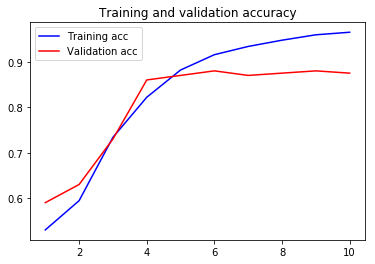

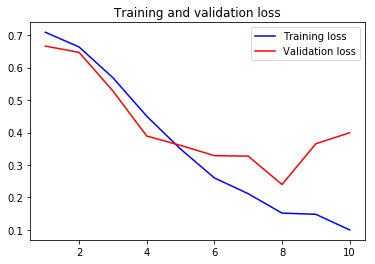

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

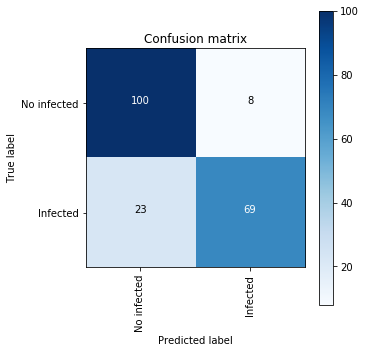

In [42]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix

dict_characters = {0: 'No infected', 1: 'Infected'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
a=X_train
b=y_train
c=X_test
d=y_test
Y_pred = model.predict_classes(c)
#Y_pred_classes = np.argmax(Y_pred,axis=1) 
confusion_mtx = confusion_matrix(d, Y_pred) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))

In [24]:
a=X_train
b=y_train
c=X_test
d=y_test
Y_pred = model.predict_classes(c)
Y_pred_classes = np.argmax(Y_pred,axis=1) 
confusion_mtx = confusion_matrix(d, Y_pred_classes) 
#plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
confusion_mtx

array([[55,  0],
       [45,  0]], dtype=int64)

In [51]:
from sklearn.metrics import log_loss
Y_pred = model.predict_proba(X_test).astype('float64')
log_loss(y_test, Y_pred, eps=1e-15)

0.43279628001755993

In [46]:
Y_pred.max()

1.0